In [ ]:
#!pip3 install opencv-python
#!pip install pafy -U
#!pip install youtube_dl

In [ ]:
#!pip install ipydagred3
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

# ImageWidget

In [1]:
import cv2
import numpy as np
from PIL import Image
import io

style = {'description_width': '250px'}
layout = {'width': '500px'}

class ImageWidget(object):
    def __init__(self, image=None, display=True):
        self.image_w = widgets.Image(format='PNG')
        self.setImage(image)
        if display == True:
            self.display()
    
    def display(self):
        display(self.image_w)  
    
    def getByteArray(self,image):    
        #return None
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    
    def evaluate(self, image=None):
        self.setImage(image)
        
    def _dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : {}}
    
    def setImage(self,image):
        #print('ImageWidget')
        if image != None:
            try:
                #print('set image', type(image))
                if isinstance(image, dict):
                    image = image['image']
                self.image_w.value = self.getByteArray(image)    
            except Exception as exception: 
                print('Exception ImageWidget', str(exception))
            
    def getImage(self):
        return Image.open(io.BytesIO(self.image_w.value))

# BaseAction

In [2]:
class BaseAction(object):
    
    def __init__(self):
        self.name = __class__.__name__
    
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self.__dict__}
    
    def merged_dict(self,parameters=None):
        old = dict()
        return {'class':old['class'],'parameters':{**old['parameters'],**parameters}}
    
    def merge(self,parameters={}):
        adict = {'class' : self.__class__.__name__, 'parameters' : {**self.__dict__, **parameters}}
        #adict = merged_dict(parameters)
        return eval(adict['class'])(**adict['parameters'])
    
    def _get_image(self,image):
        if isinstance(image, dict):
            return image['image']
        return image
    
    def _filename(self,filename=None,name=None):
        if name != None:
            return name + '_' + self.__class__.__name__ + '.json'
        if filename == None:
            return '_action_' + self.__class__.__name__ + '.json'
        return filename
    
    def save(self,filename=None,name=None):
        with open(self._filename(filename,name), 'w', encoding='utf-8') as f:
            json.dump(self.dict(), f, ensure_ascii=False, indent=4)    

    def load(self,filename=None,name=None):
        with open(self._filename(filename,name), 'r') as fp:
            file = json.load(fp)  
            return file          
        
   

In [3]:
class BaseWidget(object):
    def evaluate(self,image=None):
        return self.action.evaluate(image)
    
    def _get_image(self,image):
        if isinstance(image, dict):
            return image['image']
        return image  
    
     # write output    
    def output_result(self,update=True, result=None):
        if update == True:
            if(self.imageWidget != None):
                self.imageWidget.evaluate(result)    
                
    def get_result(self):
        if hasattr(self, 'result'):
            return self.result
        return None 

# TemplateAction

In [4]:
class TemplateAction(BaseAction):
    def __init__(self):
        pass
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
        return self.result

# TemplateWidget

In [5]:
class TemplateWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.imageWidget = imageWidget
        self.vbox   = widgets.VBox([])
        
        if action == None:
            action = TemplateAction()
            
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
        return self.result
            
    def myfunc(self,**kwargs):
        # kwargs is a dictionary.
        for k,v in kwargs.items():
             print ("%s = %s" % (k, v))
        if 'image' in kwargs.keys():
            print('found')        

# CropAction

In [6]:
# input: image, output cropped image
class CropAction(BaseAction):
    WORLD = 0
    NORMALIZED = 1
    # __init__ is a special method called whenever you try to make
    # an instance of a class. As you heard, it initializes the object.
    # Here, we'll initialize some of the data.
    #def __init__(self, image=None, size=None, min=[0.0,0.0], max=[1.0,1.0]):
    def __init__(self,size=None, min=None, max=None,region=None,mode=WORLD):
        self.min    = min
        self.max    = max
        self.region = None
        self.size   = size
        self.mode   = mode
        
    def dict(self):
        # return self.toNormalized().super(CropAction,self).__init__().dict()
        #return self.toNormalized().dict()
        return super(CropAction, self.toNormalized()).dict()
        
    # Problem: + 1    
    def evaluate(self, image=None):
        image = self._get_image(image)
        if self.mode == self.WORLD:
            return {'image':image.crop(self._flat())}
        return {'image':image.crop(self.fromNormalized(self.flat(), size=image.size))}      
        
    def _flat(self):
        return (self.min[0],self.min[1],self.max[0] + 1,self.max[1] + 1)
    
    def flat(self):
        return (self.min[0],self.min[1],self.max[0],self.max[1])
    
    def normalizeValue(self, value, size):
        return float (value) / size

    def fromNormalizedValue(self, value,size):
        return int(value * size)

    def normalized(self):    
        #print(self.min, self.max, self.size)
        xmin = self.normalizeValue(self.min[0],self.size[0])
        ymin = self.normalizeValue(self.min[1],self.size[1])
        xmax = self.normalizeValue(self.max[0],self.size[0])
        ymax = self.normalizeValue(self.max[1],self.size[1])
        return (xmin,ymin,xmax,ymax)    

    def toNormalized(self):
        if self.mode == self.NORMALIZED:
            return self
        _norm = self.normalized()
        return CropAction(min=[_norm[0],_norm[1]], max=[_norm[2],_norm[3]], mode=self.NORMALIZED)
    
    def toWorld(self,size):
        if self.mode == self.WORLD:
            return self
        _world = self.fromNormalized(self.flat(),size=size)
        return CropAction(min=[_world[0],_world[1]], max=[_world[2],_world[3]], size=size, mode=self.WORLD)
    
    def fromNormalized(self, values, size=None):    
        if size == None:
            size = self.size
             
        # init size to fix initMinMax problem --> is this really required
        self.size = size        
                
        #print('fromNormalized',size)        
        xmin = self.fromNormalizedValue(values[0],size[0])
        ymin = self.fromNormalizedValue(values[1],size[1])
        xmax = self.fromNormalizedValue(values[2],size[0])
        ymax = self.fromNormalizedValue(values[3],size[1])
        return [xmin,ymin,xmax,ymax]
    
    def update(self, size=None):
        to = self.normalized()
        self.size = size
        self.min[0] = self.fromNormalizedValue(to[0],size[0])
        self.min[1] = self.fromNormalizedValue(to[1],size[1])
        self.max[0] = self.fromNormalizedValue(to[2],size[0]) 
        self.max[1] = self.fromNormalizedValue(to[3],size[1]) 

# DisplayWidget
action: VideoAction (uses only VideoAction)

In [28]:
class DisplayWidget(BaseWidget):
    def __init__(self, action=None, update=None):
        self.action       = action
        self.index        = 0  # for change --> last index
        self.image        = None
        self.update       = update
        
        if action != None:
            self.init(action)
        
        _max = 5
        layout2={'width': '150px'}
        self.imageselectw = widgets.IntSlider(value=self.index, min=0,max=_max,step=1, description='image',layout=layout)
        self.imageselectw.observe(self.on_value_change_imageselectw, 'value')
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        self.skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout2)
        self.skipframes.on_submit(self.on_value_submit_skipframes)
        image_select_hbox = widgets.HBox([self.imageselectw,self.next_image_button,self.skipframes])
        self.hbox=image_select_hbox
        
        self.init(action)
        
    def init(self,action=None):
        if action != None:
            self.action = action
            self.index  = action.index
    
    def on_value_submit_skipframes(self,change):
        if self.action != None:
            self.action.skipframes = int(change.value)
        
    # select image slider
    def on_value_change_imageselectw(self,change):
        self.index = change['new']
        self.action.setIndex(change['new'])
        
        self.image = self.action.evaluate()['image']
        if self.update != None:
            self.update(self.image,update=True)
        
    def on_next_image_button_clicked(self,b):
        if self.action.index != self.index:
            #self.action = VideoAction(video=self.action.video,index=self.index)
            self.action.setIndex(self.index)
        self.action.skipframes = int(self.skipframes.value)
        self.image = self.action.evaluate()['image']
        if self.update != None:
            self.update(self.image,update=True)

# CropWidget

abhängig von parent und sources (speichert regions dort)

In [8]:
#display(DisplayWidget(action=_crop.videoAction,imageWidget=_imageWidget).hbox)
class CropWidget(BaseWidget):
    def __init__(self, action=None, videoAction=None ,parent=None, imageWidget=None, image=None):
        self.result       = None
        self.action       = action
        self.image        = image    # buffers image to be cropped
        self.parent       = parent
        
        self.imageWidget  = imageWidget # None or used to display result
        self.displayWidget = None       # TODO: remove
        
        # still needed ?
        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        self.regions = dict()
        self.regions['reset'] = cropNormalizedArea
    
        if image != None:
            action.size = image.size
    
        self.reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
        self.reset_button.on_click(self.on_reset_button_clicked)  

        self.crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
        self.crop_name.on_submit(self.on_value_submit_crop_name)
        self.crop_list = widgets.Dropdown(description='region',options=self.regions.keys())
        self.crop_list.observe(self.crop_list_on_change) 
        self.crop_bookmarks = widgets.HBox([self.crop_list, self.crop_name, self.reset_button])
        
        #self.cropx0 = self._IntSlider(description='x0',value=0)
        #self.cropx1 = self._IntSlider(description='x1')
        #self.cropx0 = widgets.IntSlider(value=0, step=1, description='x0',layout=layout)
        #self.cropx1 = widgets.IntSlider(value=0, step=1, description='x1',layout=layout)
        #self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        #self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        
        #self.crop_hbox_x = widgets.HBox([self.cropx0, self.cropx1])
        
        self.crop_hbox_x = widgets.HBox()
        self.crop_hbox_y = widgets.HBox()
        self._addIntCropSliders()
        
        self.vbox   = widgets.VBox([self.crop_bookmarks,self.crop_hbox_x, self.crop_hbox_y])
        
        # set size of image
        if action != None and videoAction != None:
            self._action_to_world(videoAction.stream.dimensions)
        
        if action != None and action.size != None:
            self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))
        
        
    ### SLIDER ############################################################    
    def _addIntCropSliders(self):
        self.cropx0 = self._IntSlider(description='x0')
        self.cropx1 = self._IntSlider(description='x1')
        self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        self.crop_hbox_x.children = (self.cropx0,self.cropx1)
        
        self.cropy0 =  self._IntSlider(description='y0')
        self.cropy1 =  self._IntSlider(description='y1')
        self.cropy0.observe(self.on_value_change_crop_ymin, 'value')
        self.cropy1.observe(self.on_value_change_crop_ymax, 'value')
        self.crop_hbox_y.children = (self.cropy0,self.cropy1)
        
    def _FloatSlider(self,description='',value=0.0,layout=layout):
        return widgets.FloatSlider(value=value,description=description, min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
    
    def _IntSlider(self,description='',value=0,max=0,layout=layout):
        return widgets.IntSlider(value=value, max=max,step=1, description=description,layout=layout)    
        
        
    # Hilfsfunktion, es gibt nur eine VideoACtion    
    def _get_VideoAction(self):
        return self.displayWidget.action
        
    def _action_to_world(self,size):
        if(self.action.mode != self.action.WORLD):
            self.action = self.action.toWorld(size=size)    
        
    ##########################################################################    
        
    # INIT    ---> creates new action !!! sets parameters for widget, depends on other actions
    # VideoAction oder parent ??????
    
    #def init(self, action=None, parent=None):
    def init(self, action=None):    
        #self.parent = parent
        self.crop_list.options=action.sources.videos[action.id]['bookmarks'].keys()
        
        ## TODO: remove ------> outside
        if self.displayWidget != None:
            self.displayWidget.init(action) 
            
        self.initMinMax()
   
    def evaluate(self,image=None):
        # Achtung schreibt image auch in ImageWidget !!!!!!! Doppelt
        self.updateImage(image)
        return self.result
    
    # after image is updated ######### size or image changed / source
    # called e.g. by DisplayWidget
    def updateImage(self,image=None,update=False):
        self.image = self._get_image(image)
        size = self.image.size
        
        if(self.action == None):
            self.action   = CropAction(size=size,min=[0,0], max=[size[0],size[1]])
        
        # action is normalized until size of image is known    
        self._action_to_world(size)
          
        if(self.action.size != size or self.cropx1.max != (size[0] - 1)):
            self.action.update(size)
            self.crop_image()
            self.initMinMax()
        else:
            self.crop_image(update=update)  
     
    # RESULT 
    def crop_image(self, update=False):
        
        if self.image != None :  
            image = self.image
        elif self.parent != None:
            image = self.parent.get_result()
        
        if image != None:
            if(self.action == None):
                self.action   = CropAction(size=image.size,min=[0,0], max=[image.size[0],image.size[1]])
            
            self.result = self.action.evaluate(image=image)
            
            # write output
            self.output_result(update=update,result=self.result)
            #if update == True:
            #    if(self.imageWidget != None):
            #        self.imageWidget.evaluate(self.result['image'])    
        
    def initMinMax(self,size=None,cropArea = None):
        print('CropWidget','initMinMax')
        if self.action == None:
            return
        
        if size == None:
            size = self.action.size
            cropArea = self.action.flat()
        
        self.cropx0.max = size[0] - 1
        self.cropx1.max = size[0] - 1
        self.cropy0.max = size[1] - 1
        self.cropy1.max = size[1] - 1

        self.cropx0.value = cropArea[0]
        self.cropy0.value = cropArea[1]
        self.cropx1.value = cropArea[2]
        self.cropy1.value = cropArea[3]    
        
    def on_value_change_crop_xmin(self,change):
        #print(change.owner)
        #print(type(change['new']))
        self.cropx1.min  = change['new']
        self.action.min[0] = change['new']
        self.crop_image(update=True)
            
    def on_value_change_crop_xmax(self,change):
        #print(change['new'],self.action.max)
        self.cropx0.max  = change['new']
        self.action.max[0] = change['new']
        self.crop_image(update=True)

    def on_value_change_crop_ymin(self,change):
        self.cropy1.min  = change['new']
        self.action.min[1] = change['new']
        self.crop_image(update=True)

    def on_value_change_crop_ymax(self,change):
        self.cropy0.max  = change['new']
        self.action.max[1] = change['new']
        self.crop_image(update=True)        
        
    # add/update bookmark of current video source
    def on_value_submit_crop_name(self,change):
        #self.parent.sources.videos[self.parent.id]['bookmarks'][change.value] = self.action.normalized()
        self._get_VideoAction().sources.videos[self._get_VideoAction().id]['bookmarks'][change.value] = self.action.normalized()
        
        if change.value not in self.crop_list.options:
            self.crop_list.options = list(self.crop_list.options) + [change.value] 
        self.crop_list.value = change.value
        
    def crop_list_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.crop_name.value = change['new']
            #self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.displayWidget.action.id]['bookmarks'][change['new']]))
            self.initMinMax(self.action.size,self.action.fromNormalized(self._get_VideoAction().sources.videos[self._get_VideoAction().id]['bookmarks'][change['new']]))
            
    def on_reset_button_clicked(self,b):
        self.action.min = [0,0]
        self.action.max = [self.image.size[0],self.image.size[1]]
        self.initMinMax()
        self.crop_name.value = ''

# Resize

In [9]:
####################### scale
options={'NEAREST' : Image.NEAREST,'BOX' : Image.BOX,'BILINEAR' : Image.BILINEAR,'HAMMING' : Image.HAMMING,'BICUBIC' : Image.BICUBIC,'LANCZOS' : Image.LANCZOS}
#options={Image.NEAREST,Image.BOX,Image.BILINEAR,Image.HAMMING,Image.BICUBIC,Image.LANCZOS}
#size_options = {(128,128),(224,224),(240,240),(256,256),(299,299),(300,300),(320,320),(513,513)}
size_options = {'(128,128)' : (128,128), '(224,224)' : (224,224), '(240,240)' : (240,240), '(256,256)' : (256,256),
                '(299,299)' : (299,299),'(300,300)' : (300,300),'(320,320)' : (320,320),'(513,513)' : (513,513),
                '(640,480)' : (640,480)}


class ResizeAction(BaseAction):
    def __init__(self,size=None,use_w=False,use_h=False,algorithm=Image.NEAREST):
        self.size=size
        self.use_w=use_w
        self.use_h=use_h
        self.algorithm=algorithm
        
    def evaluate(self,image=None):
        try:
            w = self.size[0]
            h = self.size[1]
            #print(size,w,h)
            imagea = image

            ratio = h / imagea.size[1]
            newsize = (int(ratio * imagea.size[0]), int(ratio * imagea.size[1]) )

            ratio = w / imagea.size[0]
            h2 = int(ratio * imagea.size[1])
            w2 = int(ratio * imagea.size[0])
            if h2 > h:
                ratio = h / imagea.size[1]
                h2 = int(ratio * imagea.size[1])
                w2 = int(ratio * imagea.size[0])
            newsize = (w2, h2 )

            imageb = imagea.resize(newsize,self.algorithm)

            v = (int((self.size[0]-imageb.size[0])/2), int((self.size[1]-imageb.size[1])/2))
            new_im = Image.new("RGB", self.size) 
            new_im.paste(imageb, v)
            return {'image':new_im}       
        except:
            return {'image':image}

# ResizeWidget

In [10]:
class ResizeWidget(BaseWidget):
    def __init__(self, action=None, parent=None, imageWidget=None, image=None):
        self.result        = {'image':image} 
        self.action       = action
        self.parent       = parent
        self.imageWidget  = imageWidget
                
        self.algorithmw = widgets.Dropdown(options=options,  description='algorithm', value = 0,style=style, layout=layout)
        self.algorithmw.observe(self.algorithmw_on_change,'value') 
        self.sizew = widgets.Dropdown(options=size_options,  description='sizes', style=style, layout=layout)
        self.sizew.observe(self.sizew_on_change,'value') 

        self.widthw  = widgets.Text(description = 'width',value = '640', style=style, layout=layout,disabled=False)
        self.heightw = widgets.Text(description = 'height',value = '480', style=style, layout=layout,disabled=False)
        self.update_button = widgets.Button(description='Resize', disabled=False, tooltip='resize',style=style, layout=layout)
        self.update_button.on_click(self.on_update_button_clicked)  
        
        self.vbox   = widgets.VBox([self.algorithmw,self.sizew,self.widthw,self.heightw,self.update_button])
        
    def algorithmw_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.update()

    def sizew_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.widthw.value  =  str(change['new'][0])        
            self.heightw.value =  str(change['new'][1])  
            self.update()
            
    def update(self):
        # get current image
        image = self.parent.result['image'] 
        
        if image != None:
            new_size = (int(self.widthw.value),int(self.heightw.value))
            self.action = ResizeAction(size=new_size,algorithm=self.algorithmw.value)
            self.result = self.action.evaluate(image=image)
            self.output_result(result=self.result)
            
    # the result: resized_image    
    def on_update_button_clicked(self,b):  
        self.update()

# FileWidget

In [11]:
import ipywidgets as widgets
from IPython.display import display
vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

class FileWidget(BaseWidget):
    def __init__(self, child=None, filename = 'videos.json'):
        self.data = None
        
        self.filename = widgets.Text(description = 'filename',value = filename, style=vstyle, layout=vlayout,disabled=False)    
        self.save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
        self.save_button.on_click(self.on_save_button_clicked)  
        self.load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
        self.load_button.on_click(self.on_load_button_clicked)  
        self.delete_button = widgets.Button(description='Delete', disabled=False, tooltip='reset all values',style=style)
        self.delete_button.on_click(self.on_video_delete_button_clicked)  
        self.hbox = widgets.HBox([self.filename,self.load_button,self.save_button])
        
    def _save(self,filename='actions.json', data=None):
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)    

    def _load(self,filename='actions.json'):
            with open(filename, 'r') as fp:
                file = json.load(fp) 
                print(file)
                return file     

    def on_load_button_clicked(self,b): 
        filename = self.filename.value
        self.data = self._load(filename=filename)

    def on_save_button_clicked(self,b):
        filename = self.filename.value 
        self._save(filename=filename, data=self.data)
            

    def video_clear_button_clicked(self,b):    
        self.video_url.value = ''
        self.video_title.value = ''
        self.video_location.value = ''
        
   
    def on_video_delete_button_clicked(self,b):
        del self.sources.videos[self.video_urls.value]

In [12]:
#fw = FileWidget(filename = '../videos.json')
#display(fw.hbox)

# ContrastBrightnessAction

In [13]:
class ContrastBrightnessAction(BaseAction):
    def __init__(self, contrast=None, brightness=None):
        self.contrast = contrast
        self.brightness = brightness

    def change_contrast(self,img, level):
        factor = (259 * (level + 255)) / (255 * (259 - level))
        def contrast(c):
            return 128 + factor * (c - 128)
        return img.point(contrast)

    #constant by which each pixel is divided
    def change_brightness(self,im,constant=0.31):
        source = im.split()
        R, G, B = 0, 1, 2
        Red = source[R].point(lambda i: i/constant)
        Green = source[G].point(lambda i: i/constant)
        Blue = source[B].point(lambda i: i/constant)
        im = Image.merge(im.mode, (Red, Green, Blue))
        im.save('modified-image.jpeg', 'JPEG', quality=100)
        return im

    def getByteArray(self,image):    
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr

    def _enhance_image(self, im, contrast=0, brightness=1.0):
        im = self.change_contrast(im, contrast)
        im = self.change_brightness(im, brightness)
        return im

    def evaluate(self, image=None):
        _image = self._get_image(image)
        return {'image':self._enhance_image(_image, self.contrast, self.brightness)}
        
layout = {'width': '500px'}
style = {'description_width': '50px'}
    
class ContrastBrightnessWidget(BaseWidget):
    def __init__(self,action=None,imageWidget=None,layout=layout,style=style):
        self.action = action
        self.imageWidget  = imageWidget # None or used to display result
        self._image = None
                
        self.contrast_w    = widgets.IntSlider(value=0,description='contrast', min=-1000, max=1000, step=1,layout=layout)
        self.brightness_w  = widgets.FloatSlider(value=1.0,description='brightness', min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
        #results_w = widgets.Text(description='results',value = '0', style=style, layout=layout)
        #image_w2      = widgets.Image(format='PNG')
        self.contrast_w.observe(self.on_value_change_enhance,'value')
        self.brightness_w.observe(self.on_value_change_enhance,'value')
        self.vbox   = widgets.VBox([self.contrast_w,self.brightness_w])
        #display(contrast_w,brightness_w,results_w,image_w2)

        if(self.action == None):
            self.action   = ContrastBrightnessAction(contrast=0,brightness=1.0)
        
    def on_value_change_enhance(self,change):
        self.action.contrast=self.contrast_w.value
        self.action.brightness=self.brightness_w.value        
        self.updateImage(update=True)
        
        #action._enhance_image(_image, contrast=contrast_w.value, brightness=brightness_w.value)
        #results_w.value = str(int(1))
        #image_w2.value = getByteArray(im)

    def evaluate(self,image=None):
        # Achtung schreibt image auch in ImageWidget !!!!!!! Doppelt
        self.updateImage(image=image)
        
        return self.result            
                
    # RESULT 
    # after image is updated 
    # called e.g. by DisplayWidget
    def updateImage(self,image=None,update=False):
        if(image != None):
            self._image = self.action._get_image(image)
        
        if(self._image != None):  
            
            self.result = self.action.evaluate(image=self._image)
            
            # write output
            if update == True:
                if(self.imageWidget != None):
                    self.imageWidget.evaluate(self.result['image'])  

# _image = <Bild, das verändert werden soll>
#_image = _crop.image

In [14]:
#_cbw = ContrastBrightnessWidget(imageWidget=ImageWidget())
#display(_cbw.vbox)
#_cbw.updateImage(_crop.result, update=True)
#_cbw.action.save()

# LiveVideoSources

In [15]:
import json
import pafy 

class LiveVideoSources():
    def __init__(self, filename='videos.json'):
        self.filename = filename
        
        self.videos = None
        self.load()
        
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : {'filename':self.filename}}     
        
    def get_keys(self):
        keys = {}
        for key, value in self.videos.items():
            keys[value['title']] = key
        return keys
        
    def load(self):
        with open(self.filename, 'r') as fp:
            self.videos = json.load(fp)  
            #return videos
            
    def save(self,filename=None):
        if filename == None:
            filename = self.filename
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.videos, f, ensure_ascii=False, indent=4)

# LiveVideoSourcesWidget

In [16]:
import ipywidgets as widgets
from IPython.display import display
vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

class LiveVideoSourcesWidget(BaseWidget):
    def __init__(self, child=None, filename = 'videos.json', action=None, id=None, imageWidget=None):
        self.sources = action  # to load/save meta data
        self.child = child
        self.action = None   # VideoAction - only for childs ????? obsolete ????
        #self.video = None    # to get meta data
        #self.id = None
        
        if(self.sources != None):
            filename = self.sources.filename
        
        self.video_filename = widgets.Text(description = 'filename',value = filename, style=vstyle, layout=vlayout,disabled=False)    
        self.video_save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
        self.video_save_button.on_click(self.on_video_save_button_clicked)  
        self.video_load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
        self.video_load_button.on_click(self.on_video_load_button_clicked)  
        self.video_delete_button = widgets.Button(description='Delete', disabled=False, tooltip='reset all values',style=style)
        self.video_delete_button.on_click(self.on_video_delete_button_clicked)  
        self.video_urls = widgets.Dropdown(description='videos', style=vstyle, layout=vlayout,disabled=False)
        self.video_urls.observe(self.video_urls_on_change)
       
        file_hbox = widgets.HBox([self.video_filename,self.video_load_button,self.video_save_button])
        video_urls_hbox = widgets.HBox([self.video_urls,self.video_delete_button])
        file_vbox =   widgets.VBox([file_hbox,video_urls_hbox])
        
        self.video_url = widgets.Text(description = 'url',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_url.on_submit(self.on_value_submit_video_url)
        self.video_clear_button = widgets.Button(description='Clear', disabled=False, tooltip='reset all values',style=style)
        self.video_clear_button.on_click(self.video_clear_button_clicked)  
        video_url_hbox = widgets.HBox([self.video_url,self.video_clear_button])
        
        #video_streams = widgets.Text(description = 'streams',value = None, style=vstyle, layout=vlayout,disabled=True)
        #self.video_streams = widgets.Dropdown(description='streams', style=vstyle, layout=vlayout,disabled=True)
        self.video_title = widgets.Text(description = 'title',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_location = widgets.Text(description = 'location',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_country = widgets.Text(description = 'country',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_objects = widgets.Text(description = 'objects',value = '', style=vstyle, layout=vlayout,disabled=False)
        
        self.vbox   = widgets.VBox([file_vbox, video_url_hbox, self.video_title,
                                     self.video_location,self.video_country,self.video_objects])

        # used e.g. to create widget for existing action
        if(self.sources != None):
            self.video_urls.options = self.sources.get_keys()
        if(self.sources != None and id != None):
            self.setVideoContainer(self.sources.videos[id])
            #print(self.sources.get_keys())
            #print(self.video_urls.options)
            self.video_urls.value = id
        
    def videoContainerTo_Dict(self):
        container = dict()
        container['url'] = self.video_url.value
        container['title'] = self.video_title.value
        container['location'] = self.video_location.value
        container['country'] = self.video_country.value
        container['objects'] = self.video_objects.value

        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        bookmark_dict = dict()
        bookmark_dict['reset'] = cropNormalizedArea
        container['bookmarks'] = bookmark_dict
        return container

    def setVideoContainer(self,container):
        self.video_url.value = container['url']
        self.video_title.value = container['title'] 
        self.video_location.value = container['location'] 
        self.video_country.value = container['country'] 
        self.video_objects.value = container['objects'] 

    # add new url, open video to get meta data, add container to sources / this should be moved to sources   
    def on_value_submit_video_url(self,change):
        video = pafy.new(change.value)
        self.video_title.value = video.title.rsplit('2021')[0].rstrip()
        container = self.videoContainerTo_Dict()
        self.sources.videos[video.videoid] = container
        #print(container)
        
    # VideoAction ändert sich nach Laden!!!! Es sollte nur eine geben ????? FOLLOWER
    # DisplayWidget / Player erzeugen neues Bild -> Pipeline oder update CropWidget
    # Flußgraph ?
    def init_video(self, id):
        #self.video = video = pafy.new(url)  #used also to init parameters
        self.setVideoContainer(self.sources.videos[id])

        # ????????????
        if self.child != None:
            #self.action = VideoAction(sources=self.sources,id=id,video=self.video)
            self.action = VideoAction(sources=self.sources, id=id)
            #self.child.init(action=self.action, parent=self)
            self.child.init(action=self.action)
        
    def video_urls_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            id = change['new']
            #url = self.sources.videos[id]['url']  
            self.init_video(id)
            
    def video_clear_button_clicked(self,b):    
        self.video_url.value = ''
        self.video_title.value = ''
        self.video_location.value = ''
        
    def on_video_load_button_clicked(self,b): 
        filename = self.video_filename.value
        self.sources = LiveVideoSources(filename)
        self.video_urls.options = self.sources.get_keys()
        
    def on_video_save_button_clicked(self,b):
        #global videos
        self.sources.filename = self.video_filename.value
        self.sources.save()  
        
    def on_video_delete_button_clicked(self,b):
        del self.sources.videos[self.video_urls.value]

In [17]:
#_url = 'https://youtu.be/S4AG47F94Ss'
#_video = pafy.new(_url)
#_video_title = _video.title.rsplit('2021')[0].rstrip()
    

In [18]:
#_video.videoid

# Player

## HaltableActionPlayer (-> )

In [19]:
import ipywidgets as widgets
import asyncio
import time

def deleteAllTasks(name):
    for task in asyncio.all_tasks(): 
                if task.get_name() == name: 
                    task.cancel()
             
            
class BooleanField(object):
    def __init__(self):
        value=False
            
class HaltableActionExecutor:

    def __init__(self, booleanField=None,imageWidget=None,sleep=0,action=None,name=None):
        self._checkbox = booleanField
        self.imageWidget = imageWidget
        self._sleep    = sleep
        self.action  = action
        self.name = name
        
    async def my_code(self):
        # This is your user code
        while True:
            if self._checkbox.value:
                self.imageWidget.evaluate(self.action.evaluate())
                #time.sleep(float(self._sleep.value))
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes
    
    def start(self):
        task = asyncio.ensure_future(self.my_code())
        task.set_name(self.name)
        print(task)     

# Video Action

In [20]:
import pafy
import cv2
import time
import json
#from queue import Queue

class VideoAction(BaseAction):
    #def __init__(self, sources=None, id=None, index=0, skipframes=0):
    def __init__(self, sources=None, id=None, index=0, skipframes=0):    
        self.sources = sources
        self.id = id
        self.index = index
        self.skipframes = skipframes
        self._stream  = None
        self._capture = None
        
        self._last_state = {'id':self.id,'index':self.index}
        self.init(sources=sources)
        
    def dict(self):
        parameters = {'id':self.id,'index':self.index,'skipframes':self.skipframes}
        return {'class' : self.__class__.__name__, 'parameters' : parameters} 
        
    def init(self, sources=None, video=None):
        self.video = video
        if video == None and sources != None:
            self.sources = sources
            url = self.sources.videos[self.id]['url']   
            self.video = video = pafy.new(url)
        
        self.setIndex(self.index)
        
        
    # save video meta data    
    def saveVideo(self,filename='videos.json', videos=None):
        #print(videos)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(videos, f, ensure_ascii=False, indent=4)
        
    def loadVideo(self,filename='videos.json'):
        with open('videos.json', 'r') as fp:
            videos = json.load(fp)  
            return videos    
        
    # select stream   
    def _setIndex(self,index):
        self.index = index
        self._last_state['index'] = index
        
        if self.video != None and self.index != None:
            #print(self.index)
            self._stream = self.video.streams[self.index]
            self._capture = cv2.VideoCapture(self._stream.url)
            
    # deprecated        
    def setIndex(self,index):    
        self._setIndex(index)
        
    # TODO: check if index was updated
    # read next image of current stream     
    def evaluate(self, image=None):
        if self._last_state['index'] != self.index:
            self._setIndex(self.index)
        return {'image':self.readImage()}    
        
    # read next image of current stream    
    def readImage(self):
        self.skipFrames(self.skipframes)
        grabbed, frame = self._capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None

    def readImages(self,number):
        images = []
        for idx in range(0, number):
            grabbed, frame = self._capture.read()
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            images.append(image)

            for i in range(0, self.skipframes):
                grabbed, frame = self._capture.read()
                #print('skip',i)
        return images

    def skipFrames(self,skipframes=0):
        for i in range(0, skipframes):
                grabbed, frame = self._capture.read()
    
    def _readImageOfStream(self,stream):
        capture = cv2.VideoCapture(stream.url)
        grabbed, frame = capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None
    
    def getVstreams(self,indexes=None):
        global vstreams
        vstreams=[]
        for stream in self.video.streams:
            if indexes == None:
                image = self._readImageOfStream(stream)
                vstreams.append(image)
            else:
                vstreams.append(None) 

        if indexes != None:
            for index in indexes:
                image = self._readImageOfStream(video.streams[index])
                vstreams[index] = image
        return vstreams

    def getVstream(self,vstreams=None, index=None):
        if vstreams[index] == None:
            image = readImageOfStream(video.streams[index])
            vstreams[index] = image
        return vstreams[index]


# EasyVideoPipeLine

In [21]:
def createActionOfDict(adict):
    return eval(adict['class'])(**adict['parameters'])

def evaluateActionDictList(_action_dict_list, _img):
    for action_dict in _action_dict_list:
        action = createActionOfDict(action_dict)
        _img = action.evaluate(_img)
    return _img
  
def saveActionDictList(filename='actions.json', actions=None):
        #print(videos)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(actions, f, ensure_ascii=False, indent=4)    

def loadActionDictList(filename='actions.json'):
        with open(filename, 'r') as fp:
            file = json.load(fp)  
            return file          

def evaluateActionList(action_list, img):
    for action in action_list:
        #print(type(action))
        img = action.evaluate(**img)
    return img

#CropAction(min=(0,0),max=(1,0.5),mode=1).evaluate(image=_action.readImage())['image']
#_actions = [CropAction(min=(0,0),max=(1,0.5),mode=1),ResizeAction(size=(900,500))]


In [22]:
class EasyVideoPipeLine(BaseAction):
    def __init__(self, sources=None, actions=None):
        self.sources=sources
        self.actions=actions
       
        if sources != None and actions != None:
            pass
            #print (self.__dict__)
            #self.init()
        
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self._create_parameters()}
    
    def _create_parameters(self):
        return {'sources' : self.sources.dict(), 'actions' : self._create_dicts(self.actions)}   
        
    def _create_dicts(self,actions):
        dicts = []
        for action in actions:
            if hasattr(action, 'dict'):
                dicts.append(action.dict())
            elif hasattr(action, 'action'):
                dicts.append(action.action.dict())  
            else:
                pass
                #print(self.__class__.__name__,'unknown')
        return dicts
    
    def _createActionOfDict(self,adict):
        return eval(adict['class'])(**adict['parameters'])
    
    def from_dict(self,adict):
        _new = self._createActionOfDict(adict)
        
        _new.sources = self._createActionOfDict(_new.sources)
        dicts = []
        for action in _new.actions:
            dicts.append( self._createActionOfDict(action))
        _new.actions = dicts
        _new.init()
        return _new
    
    def load(self,filename=None):
        _dict = super(EasyVideoPipeLine, self).load(filename=filename)
        return  self.from_dict(_dict)
    
    def init(self):
        self.actions[0].init(sources=self.sources)
        
    def evaluate(self, image=None):
        return evaluateActionList(self.actions, {})

# TabWidget

In [23]:
class TabWidget(BaseAction):
    def __init__(self, action=None, displayWidget=None, imageWidget=None):
        self.action=action
        self.displayWidget = displayWidget
        self.imageWidget = imageWidget
        self.tab_idx = 0
        self._widgets = []
        self._widgets_vbox = []
        self._dict = {'CropAction':'CropWidget', 'ResizeAction':'ResizeWidget', 'LiveVideoSources':'LiveVideoSourcesWidget',
                     'ContrastBrightnessAction':'ContrastBrightnessWidget'}
        
        self.tab  = widgets.Tab(children = self._widgets_vbox)
        self.tab.observe(self.on_select, names='selected_index')  
        
    # setzt auch parent ??? Dann kann es aber keine Lücken geben. --> besser zunächst extern    
    def add(self,_class):    
        _name = _class.__class__.__name__
        #_class = eval(_dict[_name])(action=_action, imageWidget=_imageWidget2)
        self._widgets.append(_class)
        self._widgets_vbox.append(_class.vbox)
        self.tab.children = self._widgets_vbox  
        self.tab.set_title(len(self._widgets)-1, _name)
            
    def create_widget(self,action=None, imageWidget=None):
        if isinstance(action, dict):
            action = eval(action['class'])(**action['parameters'])
        
        _name = action.__class__.__name__
        if _name in self._dict.keys():
            _class = eval(self._dict[_name])(action=action, imageWidget=imageWidget)
            self.add(_class)
            return _class
        return None

    def evaluateWidgetActionList(self,img, start=1, end=None):
        for index in range(start,end):
            img = self._widgets[index].evaluate(**img)
        return img

    # update interessant für Widget-Parameter
    # evaluate: berechnet image-Pipeline
    def on_select(self,widget):
        #     get the correct Output widget based on the index of the selected tab
        self.tab_idx = widget['new']  
        def _doit(image,update=False):
            #_imageWidget.evaluate(_crop.displayWidget.image)
            return self.imageWidget.evaluate(self.evaluateWidgetActionList(self.displayWidget.action.evaluate(), start=1, end=self.tab_idx+1))
        self.displayWidget.update = _doit
        #_doit(_widgets[0].evaluate())
        self.imageWidget.evaluate(self.evaluateWidgetActionList(self.displayWidget.action.evaluate(), start=1, end=self.tab_idx+1))    
        
    def evaluate(self, image=None):
        #image = self._get_image(image)    
        self.imageWidget.evaluate(self.evaluateWidgetActionList(self.displayWidget.action.evaluate(), start=1, end=self.tab_idx+1)) 

In [24]:
#_tab = TabWidget()
#display(_tab.tab)

In [25]:
#_tab.add(_videoSources) 
#_tab.add(_crop) 
#_tab.add(_resize)

# Application

In [30]:
_imageWidget = ImageWidget(display=False)
_crop = CropWidget(imageWidget=_imageWidget)
_videoSources = LiveVideoSourcesWidget(child=_crop, filename = '../videos.json')
_resize = resizeWidget = ResizeWidget(action=ResizeAction(),parent=_crop,imageWidget=_imageWidget)
_widgets = [_videoSources,_crop,_resize]
_pipeline = EasyVideoPipeLine(sources=_videoSources.sources, actions=_widgets)

#_crop.displayWidget = DisplayWidget(action=_crop.videoAction, update=_crop.updateImage)
_crop.displayWidget = DisplayWidget(update=_crop.updateImage)
display(_crop.displayWidget.hbox)

_tab  = widgets.Tab(children = [_videoSources.vbox, _crop.vbox, _resize.vbox])
_tab.set_title(0, 'videos')
_tab.set_title(1, 'crop')
_tab.set_title(2, 'resize')
display(_tab)

_imageWidget.display()

def evaluateWidgetActionList(widgets, img, start=1, end=None):
    for index in range(start,end):
        img = widgets[index].evaluate(**img)
    return img

# update interessant für Widget-Parameter
# evaluate: berechnet image-Pipeline
def print_on_select(widget):
    #     get the correct Output widget based on the index of the selected tab
    tab_idx = widget['new']  
    def _doit(image,update=False):
        #_imageWidget.evaluate(_crop.displayWidget.image)
        return _imageWidget.evaluate(evaluateWidgetActionList(_widgets, {'image':_crop.displayWidget.image}, start=1, end=tab_idx+1))
    _crop.displayWidget.update = _doit
    #_doit(_widgets[0].evaluate())
    _imageWidget.evaluate(evaluateWidgetActionList(_widgets, _widgets[0].evaluate(), start=1, end=tab_idx+1))
        
_tab.observe(print_on_select, names='selected_index')

Image(value=b'', format='PNG')

In [ ]:
#_crop.parent.action.id
#_crop.displayWidget.action.__dict__ 
_crop.displayWidget.action.save()

In [ ]:
_crop.action.dict()

In [ ]:
def save(filename='_action.json'):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(_crop.action.dict(), f, ensure_ascii=False, indent=4)    

save()

In [ ]:
def load(filename='_action.json'):
    with open(filename, 'r') as fp:
        file = json.load(fp)  
        return file        
    
load()

In [ ]:
_crop.action.load()

In [ ]:
#_widgets[1].videoAction.__dict__
#_crop.displayWidget.image
#_imageWidget.evaluate(_crop.displayWidget.image)
#_crop.displayWidget.image
_imageWidget.evaluate(evaluateWidgetActionList(_widgets, _crop.videoAction.evaluate(), start=1, end=3))


# Work

In [ ]:

#results_w.value = str('10')
#results_w
#_videoSources.video_urls.options = list('(128,128)' : (128,128))
#_videoSources.video_urls.options = {'Hallo':'Ntt1wwgCEOQ','Hallo2':'Ntt1wwgCEOQ'}

#for _video in _videoSources.sources.videos:
#    print(video)

In [ ]:
display(DisplayWidget(action=_crop.videoAction,imageWidget=_imageWidget).hbox)

In [ ]:
#VideoAction(sources=_videoSources.sources,id=_videoSources.id).dict()


def createActionOfDict(adict):
    return eval(adict['class'])(**adict['parameters'])
#createActionOfDict(_videoSources.sources.dict()).videos

#_crop.videoAction.dict()['parameters']['index']=2
_action = _crop.videoAction.dict()
_action= createActionOfDict(_action)

In [ ]:
_crop.action.toNormalized().dict(),_resize.action.dict(),_crop.videoAction.dict()

In [ ]:
_crop.action.dict()


In [ ]:
#_action.init(sources=_videoSources.sources)
#_videoSources.sources.dict()
_action.init(sources=_action.sources)

In [ ]:
df['parameters']['index']=2

In [ ]:
df = _action.dict()
_action= createActionOfDict(df)

In [ ]:

#{ **df['parameters'], **{'index':3,'skipframes':5} }

def modify_parameters(old,new):
    #return {'class':old['class']}
    return {'class':old['class'],'parameters':{**old['parameters'],**new}}

#_action = merge_dict(_crop.videoAction.dict(), {'index':4,'skipframes':5})
#_action= createActionOfDict(_action)
#_action.init(sources=_videoSources.sources)

#_new_parameters = {'index':3,'skipframes':5, 'sources':_videoSources.sources}
_new_parameters = {'index':3,'skipframes':5}
#_action = createActionOfDict(modify_parameters(_crop.videoAction.dict(),_new_parameters))
_action = _crop.videoAction.merge(parameters=_new_parameters)

In [ ]:
{**_crop.videoAction.__dict__,**_new_parameters}


In [ ]:
CropAction(min=(0,0),max=(1,0.5),mode=1).evaluate(image=ResizeAction(size=(700,500)).evaluate(image=_action.readImage())['image'])['image']

# Pipeline

In [ ]:
_pipeline = EasyVideoPipeLine(sources=_videoSources.sources, actions=_widgets)
_pipeline.dict()
#_tmp2 = createActionOfDict(_tmp.dict())

In [ ]:
_pipeline.save(name='test')
#_pipeline.load().dict()

In [ ]:
#_pipeline.dict()
#_pipeline._filename()
_pipeline.save()

In [ ]:
#_pipeline_dict = _pipeline.dict
_pipeline_dict = _pipeline.load()

In [ ]:
_tmp4 = EasyVideoPipeLine().from_dict(_pipeline_dict)
#_tmp4.init()
_imageWidget2 = ImageWidget(display=True)
_tmp4.actions.append(_imageWidget2)

In [ ]:
_tmp4.actions[0].setIndex(5)
_tmp4.actions[0].skipframes = 60
_tmp4.evaluate()

In [ ]:
def _update(image):
    #print(image)
    _tmp4.evaluate()
display(DisplayWidget(action=_tmp4.actions[0], update=_update).hbox)

In [ ]:

#_tmp5 = EasyVideoPipeLine().from_dict(_tmp4.dict())
_tmp5 = EasyVideoPipeLine().load()

In [ ]:
_tmp5.evaluate()['image']

# Create Widgets of pipeline

In [ ]:

_tmp4.dict()['parameters']['actions'][1]
#createActionOfDict(_tmp4.dict()['parameters']['sources'])
_tmp4.dict()['parameters']['sources']

In [ ]:
_pipeline_dict = _pipeline.load()
_tmp4 = EasyVideoPipeLine().from_dict(_pipeline_dict)
_tmp4_sources = createActionOfDict(_tmp4.dict()['parameters']['sources'])
_tmp4_video = createActionOfDict(_tmp4.dict()['parameters']['actions'][0])
_tmp4_crop  = createActionOfDict(_tmp4.dict()['parameters']['actions'][1])
_tmp4_video.init(sources=_tmp4_sources)
image = _tmp4_video.evaluate()['image']

In [ ]:
_tmp4 = EasyVideoPipeLine().load()

In [ ]:
_tmp4.actions

In [ ]:
tab  = widgets.Tab(children = [_videoSources.vbox, _crop.vbox, _resize.vbox])
tab.set_title(0, 'videos')
tab.set_title(1, 'crop')
tab.set_title(2, 'resize')
display(tab)

## tab

In [59]:
_tmp4 = EasyVideoPipeLine().load('ecke.json')

_run = widgets.Checkbox(description='loop',value=False)
display(_run)

_displayWidget = DisplayWidget(action=_tmp4.actions[0])
display(_displayWidget.hbox)  

_imageWidget2 = ImageWidget(display=False)
_tab = TabWidget(action=_tmp4.actions[0], displayWidget=_displayWidget,imageWidget=_imageWidget2)
display(_tab.tab)
_imageWidget2.display()

_tab.create_widget(_tmp4.sources,imageWidget=_imageWidget2)

_parent = None
for _action in _tmp4.actions:
    _widget = _tab.create_widget(_action,imageWidget=_imageWidget2)
    if _widget != None:
        _widget.parent = _parent
    _parent = _widget
    
_tab._widgets[1].crop_list.options = _tmp4.actions[0].sources.videos[_tmp4.actions[0].id]['bookmarks'].keys()    
_tab._widgets[1].parent = _tmp4.actions[0]
_tab._widgets[1].displayWidget = _displayWidget

_tab._widgets[2].parent = _tab._widgets[1]

exe = HaltableActionExecutor(booleanField=_run,imageWidget=_imageWidget2,sleep=0,action=_tab,name='test')
#exe.start()

Checkbox(value=False, description='loop')

Tab()

Image(value=b'', format='PNG')

In [ ]:
#_tmp4.dict()
#_tab.evaluate()
_tab._widgets[1].get_result()
_tab._widgets[2].parent

In [ ]:
_widget = CropWidget(action=CropAction(min=[0.0,0.0],max=[1.0,1.0],mode=CropAction.NORMALIZED),imageWidget=_imageWidget2)
_tab.add(_widget)
_widget.parent = _widgets[len(_widgets)-2]

In [ ]:
_widget.__dict__

In [ ]:
_widget.action.__dict__

In [ ]:
def myfunc(**kwargs):
    # kwargs is a dictionary.
    for k,v in kwargs.items():
         print ("%s = %s" % (k, v))
    if 'image' in kwargs.keys():
        print('found')
    
myfunc(result=5, image=None)

In [62]:
_tab.add(TemplateWidget())

In [ ]:
_tab._widgets[3].result

In [ ]:
_tab.create_widget(ContrastBrightnessAction().load(),imageWidget=_imageWidget2)

In [ ]:
_tab._widgets[3].contrast_w.max = 5000
_tab._widgets[3].brightness_w.max = 2.0

In [ ]:
_tmp4.actions[0].index = 5
exe.action=_tab._widgets[1].action

In [ ]:
_run = widgets.Checkbox(description='loop',value=False)
display(_run)
exe = HaltableActionExecutor(booleanField=_run,imageWidget=_imageWidget2,sleep=0,action=_tmp4,name='test')
exe.start()

In [ ]:
asyncio.all_tasks()

In [ ]:
asyncio.Task.current_task().name = "#{}".format('hallo')



In [ ]:
deleteAllTasks('test')

In [ ]:
#_imageWidget2.evaluate(_tab.evaluateWidgetActionList(_tab._widgets[0].evaluate(), start=1, end=1))
#_tab._widgets[0].evaluate()
#_tab._widgets[1].action
#_tmp4.sources
#_tab._widgets[0].__dict__
#_displayWidget.action.evaluate()['image']
#_displayWidget.evaluate()['image']
#_displayWidget.__dict__
#_tmp4.actions[0].dict()
#_displayWidget.action.dict()
#_tab.displayWidget.image
#self.crop_list.options=self.parent.sources.videos[self.id]['bookmarks'].keys()
#_tmp4.actions[0].sources.videos[_tmp4.actions[0].id]['bookmarks'].keys()

#_tab._widgets[0].sources.__dict__
#_tmp4.actions[0].dict()
#_tmp4.actions[0].__dict__
#_tmp4.actions[0]
#_displayWidget.action.__dict__
#_tmp4.actions[0].dict()
#DisplayWidget(action=_tmp4.actions[0]).action.__dict__
#_tab._widgets[2].parent = _tab._widgets[1]
_tmp4.save()

In [ ]:
self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.id]['bookmarks'][change['new']]))

In [ ]:
_tmp4 = EasyVideoPipeLine().load()

#_dict = {'CropAction':'CropWidget', 'ResizeAction':'ResizeWidget','VideoAction':'LiveVideoSourcesWidget'}
_dict = {'CropAction':'CropWidget', 'ResizeAction':'ResizeWidget', 'LiveVideoSources':'LiveVideoSourcesWidget'}

_imageWidget2 = ImageWidget(display=False)

_widgets = []
_widgets_vbox = []

def add_to_widgets(_action):
    _name = _action.__class__.__name__
    if _name in _dict.keys():
        _class = eval(_dict[_name])(action=_action, imageWidget=_imageWidget2)
        _widgets.append(_class)
        _widgets_vbox.append(_class.vbox)

add_to_widgets(_tmp4.sources)        
for _action in _tmp4.actions:
    add_to_widgets(_action)
        
_tab  = widgets.Tab(children=_widgets_vbox)
for ind, _widget in enumerate(_widgets):
    _tab.set_title(ind, _widget.action.__class__.__name__)
    
display(_tab)
_imageWidget2.display()

In [ ]:
_tmp4_video = _tmp4.actions[0]
_tmp_displayWidget = DisplayWidget(action=_tmp4_video,update=_tmp4_crop_widget.updateImage)
display(_tmp4_crop_widget.displayWidget.hbox)

In [ ]:
_tmp4_crop = _tmp4.actions[1]
_tmp4_crop_widget = CropWidget(action=_tmp4_crop)
display(_tmp4_crop_widget.vbox)

_tmp4_video = _tmp4.actions[0]
_tmp4_crop_widget.displayWidget = DisplayWidget(action=_tmp4_video,update=_tmp4_crop_widget.updateImage)
display(_tmp4_crop_widget.displayWidget.hbox)

_image = _tmp4.actions[0].evaluate()
_tmp4_crop_widget.updateImage(_image)


In [ ]:
_tmp4.actions[1].evaluate(_image)['image']

In [ ]:

_tmp4.actions[1].__dict__, _tmp4_crop_widget.action.__dict__

In [ ]:
#_tmp4.dict()
_tmp4_crop.dict()
_tmp4_video.dict()
_tmp4_video.stream.dimensions
_tmp4_crop.__dict__

In [ ]:
_tmp4.actions[1].__dict__, _tmp4_crop_widget.action.__dict__

In [ ]:
_tmp4_crop_widget = CropWidget(action=_tmp4_crop, videoAction=_tmp4_video ,parent=None)
display(_tmp4_crop_widget.vbox)

_tmp4_crop_widget.displayWidget = DisplayWidget(action=_tmp4_video,update=_tmp4_crop_widget.updateImage)
display(_tmp4_crop_widget.displayWidget.hbox)



In [ ]:
_tmp4_crop_widget.action.dict()

In [ ]:
_tmp4_sources.get_keys()
_tmp4_sources.videos[_tmp4_video.id]

In [ ]:
#_tmp4_sources_widget = LiveVideoSourcesWidget(child=_tmp4_crop_widget, filename = '../videos.json', action=_tmp4_sources, id=_tmp4_video.id)
_tmp4_sources_widget = LiveVideoSourcesWidget(filename = '../videos.json', action=_tmp4_sources, id=_tmp4_video.id)
display(_tmp4_sources_widget.vbox)

In [ ]:
_tmp4_sources_widget.child = _tmp4_crop_widget

In [ ]:
_tmp4_crop_widget.displayWidget.image

In [ ]:
_tmp4.dict()

In [ ]:
_tmp4_crop.size

In [ ]:
#_tmp4_crop.evaluate(_tmp4_video.evaluate()['image'])['image']

image = _tmp4_video.evaluate()['image']
#_tmp4_crop.fromNormalized(_tmp4_crop.flat(), size=image.size)
#_tmp4_crop.flat()
image

In [ ]:
_tmp4_crop.__dict__

In [ ]:
self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))

In [ ]:
#_tmp4_crop.__dict__
#_tmp4_video.evaluate()
#_tmp4_video.__dict__
_tmp4_crop.action.__dict__

In [ ]:
#_tmp4_crop_widget.action.__dict__
#_tmp4_crop_widget.action.normalized()
#_tmp4_crop_widget.action.min
#_tmp4_crop_widget.action.crop(_tmp4_crop_widget.action._flat())
#_tmp4_crop_widget.action._flat(), _tmp4_crop_widget.action.__dict__
#_tmp4_crop.__dict__
#_tmp4_crop.flat()
#_tmp4_crop.toWorld(image.size).__dict__
#_tmp4_crop_widget.action.__dict__
_tmp4_crop_widget.result['image']
#_tmp4_crop_widget.displayWidget.image

In [ ]:
#_tmp4_sources.__dict__
_tmp4_sources_widget.video_urls.value
#_tmp4_sources_widget.id
_tmp4_video.id

In [ ]:
#_tmp4_video.__dict__
#_tmp4_crop_widget.displayWidget.on_next_image_button_clicked('')

#action.update(size)

_tmp4_crop_widget.action.__dict__
_size = _tmp4_crop_widget.displayWidget.image.size
#_tmp4_crop_widget.action.update(_size)

_tmp4_crop_widget.action.mode == _tmp4_crop_widget.action.WORLD

_tmp4_crop_widget.action.toWorld(size=_size).__dict__

In [ ]:
#_tmp4_video.evaluate()['image']
image = _tmp4_crop_widget.displayWidget.image
#_tmp4_crop_widget.updateImage(_tmp4_crop_widget.displayWidget.image)

#_tmp4_crop_widget.action.fromNormalized(_tmp4_crop_widget.action.flat(), size=image.size)
#_tmp4_crop_widget.action.__dict__, _tmp4_crop.__dict__
#_tmp4_crop_widget.action.__dict__, _tmp4_crop_widget.action.fromNormalized(_tmp4_crop_widget.action.flat(), size=image.size).__dict__
image

In [ ]:
_tmp4_crop_widget.action.__dict__, _tmp4_crop.__dict__

In [ ]:
if isinstance(_tmp.dict(), dict):
    print('dict')


#EasyVideoPipeLine().from_dict(_tmp.dict()).sources.videos

_tmp3 = EasyVideoPipeLine().from_dict(_tmp.dict())
_tmp3.actions[0].init(sources=_tmp3.sources)
_action0 = _tmp3.actions[0]
_action0.setIndex(2)
_imageWidget2 = ImageWidget(display=True)

In [ ]:
_action0.setIndex(1)

In [ ]:
_action0.skipFrames(15)
_tmp3.actions[0].evaluate()['image']
_imageWidget2.setImage(_tmp3.actions[0].evaluate())

In [ ]:
_action1 = _tmp3.actions[1]
_action2 = _tmp3.actions[2]

_action2.algorithm = Image.LANCZOS

#_action2.evaluate(_action1.evaluate(_imageWidget2.getImage())['image'])['image']

_imageWidget2.setImage(_action1.evaluate(_imageWidget2.getImage())['image'])

#_action2.dict()

In [ ]:
#_tmp3.actions[2].algorithm = Image.LANCZOS
_tmp3.actions[2].__dict__
_tmp3.actions[0].setIndex(5)
_tmp3.actions[0].skipframes = 60

In [ ]:
_tmp3.actions[0].__dict__

In [ ]:
# set result to imagewidget
_imageWidget2.evaluate(**  evaluateActionList(_tmp3.actions, {}))

In [ ]:
_actions = [ResizeAction(size=(900,500))]
evaluateActionList(_actions, {'image':_action.readImage()})['image']

In [ ]:
#_action.sources.videos[_action.id]
_action.video

In [ ]:
_videoSources.sources.videos[list(_videoSources.sources.videos.keys())[1]]

In [ ]:
_action.evaluate()['image']

In [ ]:
CropAction(min=(0,0),max=(480,640),size=(1920,1080),mode=CropAction.WORLD).dict(), CropAction(min=(0,0),max=(480,640),size=(1920,1080),mode=CropAction.WORLD).toNormalized().__dict__

# ActionStream

In [ ]:
# import the necessary packages
from threading import Thread
import sys
import cv2
# import the Queue class from Python 3
from queue import Queue

class ActionStream:
    def __init__(self, queueSize=128, action=None):
        self.action = action
        # initialize the file video stream along with the boolean
        # used to indicate if the thread should be stopped or not
        self.stopped = False
        # initialize the queue used to store frames read from
        # the video file
        self.Q = Queue(maxsize=queueSize)
        
    def start(self):
        # start a thread to read frames from the file video stream
        t = Thread(target=self.update, args=(), name="FileVideoStream")
        t.daemon = True
        t.start()
        return self      
    
    def update(self):
        # keep looping infinitely
        while True:
            # if the thread indicator variable is set, stop the
            # thread
            if self.stopped:
                return
            # otherwise, ensure the queue has room in it
            if not self.Q.full():
                # read the next frame from the file
                #(grabbed, frame) = self.capture.read()
                # if the `grabbed` boolean is `False`, then we have
                # reached the end of the video file
                #frame = self.action.readImage()
                frame = self.action.evaluate()
                grabbed = True
                if not grabbed:
                    self.stop()
                    return
                # add the frame to the queue
                self.Q.put(frame)    
                
    def evaluate(self):
        # return next frame in the queue
        return self.Q.get()
    
    def more(self):
        # return True if there are still frames in the queue
        return self.Q.qsize() > 0
    
    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True

In [ ]:
fs = ActionStream(queueSize=60,action=_tmp4).start()

In [ ]:
fs.evaluate()['image']

In [ ]:
#fs.stop()
fs.start()
fs.Q.qsize()

In [ ]:
_run = widgets.Checkbox(description='loop',value=False)
display(_run)
exe2 = HaltableActionExecutor(booleanField=_run,imageWidget=ImageWidget(display=True),sleep=0,action=fs,name='test')
exe2.start()

In [ ]:
# import the necessary packages
from threading import Thread
import sys
import cv2
# import the Queue class from Python 3
from queue import Queue

class FileVideoStream0:
    def __init__(self, queueSize=128, action=None):
        # initialize the file video stream along with the boolean
        # used to indicate if the thread should be stopped or not
        #_entry = videos[name]
        #_video  = pafy.new(_entry['url'])
        #self.stream = _video.streams[index]
        #self.capture = cv2.VideoCapture(self.stream.url)
        self.action = action
        self.stopped = False
        # initialize the queue used to store frames read from
        # the video file
        self.Q = Queue(maxsize=queueSize)
        
    def start(self):
        # start a thread to read frames from the file video stream
        t = Thread(target=self.update, args=(), name="FileVideoStream")
        t.daemon = True
        t.start()
        return self      
    
    def update(self):
        # keep looping infinitely
        while True:
            # if the thread indicator variable is set, stop the
            # thread
            if self.stopped:
                return
            # otherwise, ensure the queue has room in it
            if not self.Q.full():
                # read the next frame from the file
                #(grabbed, frame) = self.capture.read()
                # if the `grabbed` boolean is `False`, then we have
                # reached the end of the video file
                #frame = self.action.readImage()
                frame = self.action.evaluate()
                grabbed = True
                if not grabbed:
                    self.stop()
                    return
                # add the frame to the queue
                self.Q.put(frame)    
                
    def evaluate(self):
        # return next frame in the queue
        return self.Q.get()
    
    def more(self):
        # return True if there are still frames in the queue
        return self.Q.qsize() > 0
    
    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True

In [ ]:
_action.skipframes=15
fs = FileVideoStream(queueSize=60,action=_action).start()

In [ ]:
frame = fs.read() 
frame
#_imagew.setImage(frame)

In [ ]:
#_action_dict_list
_caction.dict()

In [ ]:
#_action.skipframes=10

_caction = createActionOfDict(_crop.action.toNormalized().dict())

while True:      
        try:
            frame = fs.read()
            _imagew.setImage(_caction.evaluate(image=frame['image'])['image'])
        except Exception as exception:
            print('done', str(exception))

In [ ]:
_vaction = _crop.videoAction

In [ ]:
_imagew = ImageWidget()

In [ ]:
#while fs.more():
from imutils.video import FPS
fps = FPS().start()

while True:    
    frame = fs.read()
    cv2.putText(frame, "Queue Size: {}".format(fs.Q.qsize()),
        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    _img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    _img = evaluateActionDictList(_action_dict_list,_img)
    #_imagew.setImage(_img)
    fps.update()
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

In [ ]:
fs.stop()

In [ ]:
fps.stop()
#print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
#print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

In [ ]:
fs = ActionStream(queueSize=60,action=_tmp5).start()
_frame = fs.evaluate()
_frame['image']

# VideoLoopPlayer

In [ ]:
#from queue import Queue

_action=_crop.videoAction
_action.skipframes = 60
_images = _action.readImages(40)

In [ ]:
#_images[30]
#_action.skipframes


In [ ]:
#imageWidget.setImage(_loop.evaluate()['image'])

In [ ]:
class VideoLoopAction():
    def __init__(self,images=None):
        self.index  = 0
        self.step   = 1
        self.images = images
        
    def evaluate(self):
        self.index = self.index + self.step
        if self.index > len(self.images) - 1:
            self.index = 0
    
        return {'image':self.images[self.index]}  

In [ ]:
import ipywidgets as widgets
style = {'description_width': '250px'}
layout = {'width': '500px'}

#_caction = createActionOfDict(_crop.action.toNormalized().dict())
#_vaction = fs

def on_next_button_clicked1(b):  
    #newvalue = int(frame.value) + 1
    #if newvalue == len(imgs):
    #    newvalue = 0
    #frame.value =  str(newvalue)
    #imageWidget.setImage(CropAction(**para_dict).evaluate(image=imgs[newvalue]))
    #imageWidget.setImage(_action.evaluate(image=imgs[newvalue]))
    #_img = capture.getFrame()
    #_img = imgs[newvalue]
    #_img = _vaction.readImageOfStream()
    #frame1 = fs.read()
    #_img = Image.fromarray(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    #_img = evaluateActionDictList(_action_dict_list,_img)
    #imageWidget.setImage(_img)
    frame = fs.read()
    _imagew.setImage(_caction.evaluate(image=frame['image'])['image']) 

def on_next_button_clicked(b):  
    #_img = _vaction.readImageOfStream()
    
    pass
    #_caction = _crop.action.toNormalized()
    #frame = _vaction.evaluate()
    #_img = _caction.evaluate(image=frame['image'])['image']
    #imageWidget.setImage(_img)
    
def initBufferedStream():    
    name='_hEh5wF6lxE'
    _entry = videos[name]
    _video  = pafy.new(_entry['url'])
    fs.stream = _video.streams[int(stream.value)]
    fs.capture = cv2.VideoCapture(fs.stream.url)
    
def on_download_button_clicked(b):  
    global imgs
    next_button.disabled = True
    #imgs = readImagesOfStream(video.streams[int(stream.value)],int(numberframes.value),skipframes=int(skipframes.value))
    #imgs = capture.readFrames(int(numberframes.value),skipframes=int(skipframes.value))
    global _vaction
    _vaction = VideoAction(video,index=int(stream.value),skipframes=int(skipframes.value))
    
    #initBufferedStream()
    
    frame.value = '0'
    next_button.disabled = False

def on_value_change_loop(b):
    if b['new'] == True:
        exe = HaltableExecutor(loop,sleep)
        exe.start()
        pending = asyncio.all_tasks()
        print(pending)
    else:
        for task in asyncio.all_tasks(): 
            if task.get_name() == 'test': 
                task.cancel()

    
stream     = widgets.Text(description   = 'stream',value = '1', style=style, layout=layout)
numberframes = widgets.Text(description = 'number frames',value = '10', style=style, layout=layout)
skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout)
frame = widgets.Text(description = 'frame',value = '0', style=style, layout=layout)
sleep = widgets.Text(description = 'sleep',value = '0.0', style=style, layout=layout)
loop = widgets.Checkbox(description='loop',value=False)
#loop.observe(on_value_change_loop)    
download_button = widgets.Button(description='download', disabled=False, tooltip='resize',style=style, layout=layout)
download_button.on_click(on_download_button_clicked)  
next_button = widgets.Button(description='next', disabled=False, tooltip='resize',style=style, layout=layout)
next_button.on_click(on_next_button_clicked)  
vbox = widgets.VBox([stream,numberframes,skipframes,download_button,frame,sleep,loop,next_button])
display(vbox)
imageWidget=ImageWidget()
#imageWidget.display()

In [ ]:
#imageWidget.getImage().size
#video.streams
#VideoAction.__dict__

#_vaction.skipframes = 60

#display(DisplayWidget(action=_loop,imageWidget=imageWidget).hbox)
_loop = VideoLoopAction(images=_images)
display(DisplayWidget0(action=_loop,imageWidget=imageWidget).hbox)

In [ ]:
imageWidget.setImage(_loop.evaluate())

In [ ]:
import ipywidgets as widgets
import asyncio
import time

class HaltableExecutor:

    def __init__(self, checkbox,imageWidget,sleep,action):
        self._checkbox = checkbox
        self.imageWidget = imageWidget
        self._sleep    = sleep
        self.action  = action
        
    async def my_code(self):
        # This is your user code
        while True:
            if self._checkbox.value:
                print('running')  # put your code here
                #self.function('b')
                #self.imageWidget.setImage(self.action.evaluate())
                time.sleep(float(self._sleep.value))
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes
    
    def start(self):
        print('starting')
        #asyncio.current_task().foo = "Bar"
        #asyncio.current_task().name = "#{}".format(n)
        task = asyncio.ensure_future(self.my_code())
        task.set_name('test')
        #asyncio.current_task().name = 'test'
        
#c = widgets.Checkbox(description='click me',value=False)
#display(c)        


exe = HaltableExecutor(_run,None,1,_loop)
exe.start()


In [ ]:
#ImageWidget().setImage(_tmp5.evaluate())
_tmp5.actions[0].index = 5
_tmp5.actions[0].skipframes=8

In [ ]:
_tmp5.actions[2].size = (420,360)
_tmp5.actions[2].__dict__

In [ ]:
del _tmp5.actions[2]

In [ ]:
_tmp5.actions[0].__dict__
#_tmp5.actions[0].evaluate()['image']

In [ ]:
_loop.index, _loop.step
#imageWidget.display()
_run = widgets.Checkbox(description='loop',value=False)
imageWidget=ImageWidget()
display(_run)

In [ ]:
import ipywidgets as widgets
import asyncio
import time

class HaltableExecutor:

    def __init__(self, checkbox=checkbox,sleep=sleep,class=None,function=evaluate,imageWidget=imageWidget):
        self._checkbox = checkbox
        self.imageWidget = imageWidget
        self._sleep    = sleep
        self.class     = class
        self.function  = function
        
    async def my_code(self):
        # This is your user code
        while True:
            if self._checkbox.value:
                #print('running')  # put your code here
                #self.function('b')
                self.imageWidget.setImage(self.claas.function
                time.sleep(float(self._sleep.value))
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes
    
    def start(self):
        print('starting')
        #asyncio.current_task().foo = "Bar"
        #asyncio.current_task().name = "#{}".format(n)
        task = asyncio.ensure_future(self.my_code())
        task.set_name('test')
        #asyncio.current_task().name = 'test'
        
#c = widgets.Checkbox(description='click me',value=False)
#display(c)        

#exe = HaltableExecutor(loop,sleep,on_next_button_clicked)
exe = HaltableExecutor(checkbox=_run,sleep=sleep,class=_loop,imageWidget=imageWidget)
exe.start()

In [ ]:
def deleteAllTasks(name):
    for task in asyncio.all_tasks(): 
                if task.get_name() == name: 
                    task.cancel()
                
pending = asyncio.all_tasks()
#next(iter(pending)).cancel()
len(pending)
#pending
#asyncio.current_task().set_name('test')
#next(iter(pending)).get_name()
#task, = [task for task in asyncio.all_tasks() if task.get_name() == 'test']
#task.get_name()
#deleteAllTasks('test')
pending
deleteAllTasks('test')

In [ ]:
asyncio.all_tasks()
#deleteAllTasks('Task-9')

# Coral Actions

In [ ]:
import sys
sys.path.insert(0,'/home/pi/jupyter/coral/projectposenet')
sys.path

In [78]:
!ln -s /home/pi/jupyter/coral/projectposenet/posenet_lib/  posenet_lib 
!ln -s /home/pi/jupyter/coral/projectposenet projectposenet

ln: failed to create symbolic link 'projectposenet': File exists


## PoseEngine

In [81]:
import random
from PIL import Image
from PIL import ImageDraw

colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

EDGES = (
    ('nose', 'left eye'),
    ('nose', 'right eye'),
    ('nose', 'left ear'),
    ('nose', 'right ear'),
    ('left ear', 'left eye'),
    ('right ear', 'right eye'),
    ('left eye', 'right eye'),
    ('left shoulder', 'right shoulder'),
    ('left shoulder', 'left elbow'),
    ('left shoulder', 'left hip'),
    ('right shoulder', 'right elbow'),
    ('right shoulder', 'right hip'),
    ('left elbow', 'left wrist'),
    ('right elbow', 'right wrist'),
    ('left hip', 'right hip'),
    ('left hip', 'left knee'),
    ('right hip', 'right knee'),
    ('left knee', 'left ankle'),
    ('right knee', 'right ankle'),
)

def drawPoint(image,x,y,r,rgba):
    draw = ImageDraw.Draw(image)
    leftUpPoint = (x-r, y-r)
    rightDownPoint = (x+r, y+r)
    twoPointList = [leftUpPoint, rightDownPoint]
    draw.ellipse(twoPointList, fill=rgba)

def drawPosePoints(image,poses,EDGES):    
    for pose in poses:
        #if pose.score < 0.4: continue
        rgba =  random.choice(colors)     
        #print('\nPose Score: ', pose.score)
        xys = {}
        minScoreKeypoint = 0.0
        for label, keypoint in pose.keypoints.items():
            if keypoint.score < minScoreKeypoint : continue
            #print(keypoint.point)
            #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
            drawPoint(image,keypoint.point.x,keypoint.point.y,2,rgba)
            #kp_y = int((keypoint.yx[0] ) )
            #kp_x = int((keypoint.yx[1] ) )
            kp_y = int( keypoint.point.y)
            kp_x = int( keypoint.point.x)
            
            xys[label] = (kp_x, kp_y)
            #print(' %-20s x=%-4d y=%-4d score=%.1f' %
            #      (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
        #print(xys)
    
        for a, b in EDGES:
            if a not in xys or b not in xys: continue
            ax, ay = xys[a]
            bx, by = xys[b]
            #dwg.add(dwg.line(start=(ax, ay), end=(bx, by), stroke=color, stroke_width=2))
            draw = ImageDraw.Draw(image)
            draw.line((ax,ay,bx,by), fill=128, width=3)
            #print (ax,ay,bx,b)          

In [ ]:
from pycoral.utils import edgetpu
from PIL import Image
from tflite_runtime.interpreter import load_delegate
from tflite_runtime.interpreter import Interpreter

import collections
import enum
import math
import numpy as np
import os
import platform
import sys
import time

from projectposenet.pose_engine import PoseEngine
engine = PoseEngine('projectposenet/models/mobilenet/posenet_mobilenet_v1_075_481_641_quant_decoder_edgetpu.tflite')

In [ ]:
_img = _imageWidget2.getImage()
poses, inference_time = engine.DetectPosesInImage(_img)
print('Inference time: %.f ms' % (inference_time * 1000),'recognized:', len(poses))
drawPosePoints(_img,poses,EDGES)  
_img

## Objects

In [ ]:
import time

from PIL import Image
from PIL import ImageDraw

from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
interpreter = make_interpreter('/home/pi/jupyter/coral/pycoral/test_data/ssd_mobilenet_v2_coco_quant_postprocess_edgetpu.tflite')
interpreter.allocate_tensors()

In [ ]:
#image = Image.open('/home/pi/jupyter/coral/pycoral/test_data/grace_hopper.bmp' )
image = _imageWidget2.getImage()

_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

print('----INFERENCE TIME----')

for _ in range(1):
    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    objs = detect.get_objects(interpreter,0.2, scale)
    print('%.2f ms' % (inference_time * 1000))
    
def draw_objects(draw, objs, labels):
  """Draws the bounding box and label for each object."""
  for obj in objs:
    bbox = obj.bbox
    draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                   outline='red')
    draw.text((bbox.xmin + 10, bbox.ymin + 10),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill='red')

print('-------RESULTS--------')
if not objs:
    print('No objects detected')

for obj in objs:
    print(labels.get(obj.id, obj.id))
    print('  id:    ', obj.id)
    print('  score: ', obj.score)
    print('  bbox:  ', obj.bbox)

image = image.convert('RGB')
draw_objects(ImageDraw.Draw(image), objs, labels)    

image

# Graph

In [38]:
import networkx as nx

graph = nx.DiGraph()
graph.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])

graph.nodes()

NodeView(('root', 'a', 'b', 'e', 'c', 'd'))

In [39]:
graph = nx.DiGraph()
graph.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])
nx.is_directed(graph)
nx.is_directed_acyclic_graph(graph)

False

In [40]:
from matplotlib import pyplot as plt
g1 = nx.DiGraph()
g1.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)
plt.savefig("g1.png", format="PNG")
# tell matplotlib you're done with the plot: https://stackoverflow.com/questions/741877/how-do-i-tell-matplotlib-that-i-am-done-with-a-plot
plt.clf()

<Figure size 432x288 with 0 Axes>

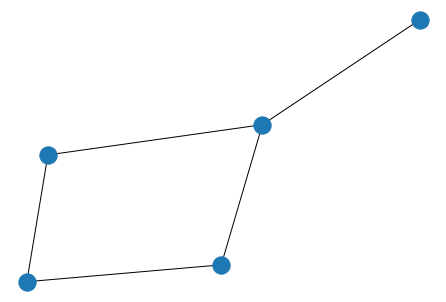

In [41]:
import pylab as p
import networkx as nx

G = nx.Graph()
G.add_edge("A","B")
G.add_edge("A","H")
G.add_edge("H","C")
G.add_edge("B","C")
G.add_edge("B","D")

nx.draw(G)
p.show()

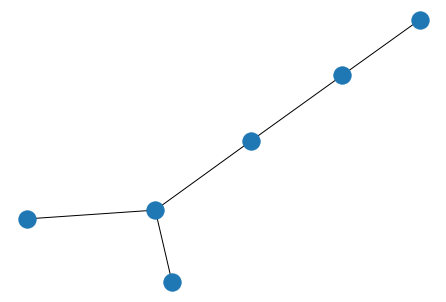

In [42]:
import pylab as p
import networkx as nx


class Node(object):
    nodes = []

    def __init__(self, label):
        self._label = label

    def __str__(self):
        return self._label

nodes = [Node(l) for l in ["A","B","C","C","D","H"]]
edges = [(0,1),(0,5),(5,2),(1,3),(1,4)]

G = nx.Graph()
for i,j in edges:
    G.add_edge(nodes[i], nodes[j])

nx.draw(G)
p.show()

In [52]:
#depth-first-search post-order. 
from networkx import DiGraph
from networkx.algorithms.traversal.depth_first_search import dfs_postorder_nodes

g = DiGraph({0: [1, 2], 1: [3, 4], 2: [5, 6]})
print(*dfs_postorder_nodes(g, source=0))


3 4 1 5 6 2 0


In [47]:
G = nx.path_graph(3)
list(nx.bfs_edges(G, 0))

G = nx.path_graph(3)
root = 2
edges = nx.bfs_edges(G, root)
nodes = [root] + [v for u, v in edges]
nodes

[2, 1, 0]

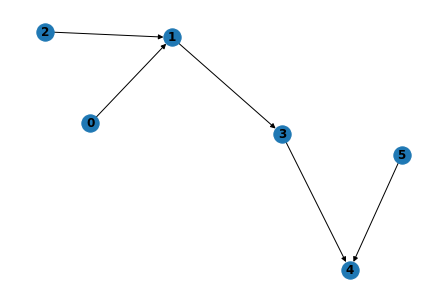

{'1': '0', '3': '1', '4': '3'}


<Figure size 432x288 with 0 Axes>

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
nodes = ['0','1','2','3','4','5']
G = nx.DiGraph(name='G')
G.add_nodes_from(nodes)
edges = [('0','1'),('2','1'),('5','4'),('1','3'),('3','4')]
G.add_edges_from(edges)

bfs = nx.bfs_predecessors(G, source='0')
bfs = dict(bfs)
nx.draw(G, font_weight='bold', with_labels=True)
plt.show()
plt.savefig('graph.png')
print(bfs)

In [50]:
graph = {
  '5' : ['3','7'],
  '3' : ['2', '4'],
  '7' : ['8'],
  '2' : [],
  '4' : ['8'],
  '8' : []
}

visited = [] # List for visited nodes.
queue = []     #Initialize a queue

def bfs(visited, graph, node): #function for BFS
  visited.append(node)
  queue.append(node)

  while queue:          # Creating loop to visit each node
    m = queue.pop(0) 
    print (m, end = " ") 

    for neighbour in graph[m]:
      if neighbour not in visited:
        visited.append(neighbour)
        queue.append(neighbour)

# Driver Code
print("Following is the Breadth-First Search")
bfs(visited, graph, '5')    # function calling

Following is the Breadth-First Search
5 3 7 2 4 8 

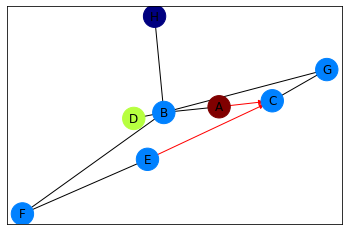

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from(
    [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
     ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
red_edges = [('A', 'C'), ('E', 'C')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()

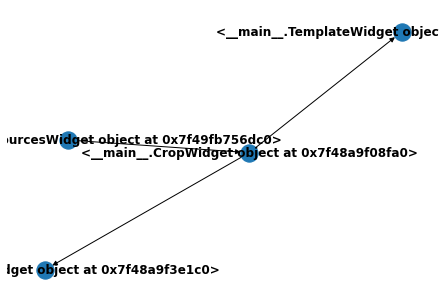

In [67]:
G = nx.DiGraph()
#G.add_edges_from( [(_tmp4.actions[0], _tmp4.actions[1]), (_tmp4.actions[1], _tmp4.actions[2])] )
G.add_edges_from( [(_tab._widgets[0],_tab._widgets[1]),(_tab._widgets[1],_tab._widgets[2]), (_tab._widgets[1],_tab._widgets[3])  ] )

nx.draw(G, font_weight='bold', with_labels=True)
plt.show()

In [73]:
#_tmp4.actions
#_tab._widgets
G.edges.keys


<bound method Mapping.keys of OutEdgeView([(<__main__.LiveVideoSourcesWidget object at 0x7f49fb756dc0>, <__main__.CropWidget object at 0x7f48a9f08fa0>), (<__main__.CropWidget object at 0x7f48a9f08fa0>, <__main__.ResizeWidget object at 0x7f48a9f3e1c0>), (<__main__.CropWidget object at 0x7f48a9f08fa0>, <__main__.TemplateWidget object at 0x7f48aa4407c0>)])>

In [68]:
def dfs_edges(G,source=None):
    """Produce edges in a depth-first-search starting at source."""
    # Based on http://www.ics.uci.edu/~eppstein/PADS/DFS.py
    # by D. Eppstein, July 2004.
    if source is None:
        # produce edges for all components
        nodes=G
    else:
        # produce edges for components with source
        nodes=[source]
    visited=set()
    for start in nodes:
        if start in visited:
            continue
        visited.add(start)
        stack = [(start,iter(sorted(G[start])))]
        while stack:
            parent,children = stack[-1]
            try:
                child = next(children)
                if child not in visited:
                    yield parent,child
                    visited.add(child)
                    stack.append((child,iter(sorted(G[child]))))
            except StopIteration:
                stack.pop()
                
dfs_edges(G)                

<generator object dfs_edges at 0x7f49fb9fa040>

# trial

In [ ]:
import requests
response = requests.get(_videoSources.video.thumb)

img_byte_arr = io.BytesIO(response.content).read()
_imagew.image_w.value = img_byte_arr

In [ ]:
_videoSources.video.thumb

# tab

In [ ]:
#!/usr/bin/env python

from Tkinter import *
import tkMessageBox
import ttk

#---------------------------------------------------------------------
class MyTab(Frame):

    def __init__(self, root, name):
        Frame.__init__(self, root)

        self.root = root
        self.name = name

        self.entry = Entry(self)
        self.entry.pack(side=TOP)

        self.entry.bind('<FocusOut>', self.alert)
        self.entry.bind('<Key>', self.printing)

        self.bind("<Button-1>", self.clickFrame)

    #-------------------------------

    def alert(self, event):
        print 'FocusOut event is working for ' + self.name + '  value: ' + self.entry.get()
        #tkMessageBox.showinfo('alert', 'FocusOut event is working for ' + self.name + '  value: ' + self.entry.get())

    #-------------------------------

    def printing(self, event):
        print event.keysym + ' for ' + self.name

    #-------------------------------

    def clickFrame(self, event):
        print "MyTab: click at (" + str(event.x) + ", " + str(event.y) + ') for ' + self.name + " (parent name: " + self.root.tab(CURRENT)['text'] + ")"


#---------------------------------------------------------------------

class Application():

    def __init__(self):

        self.tabs = {'ky':1} 

        self.root = Tk()
        self.root.minsize(300, 300)
        self.root.geometry("1000x700")

        self.notebook = ttk.Notebook(self.root, width=1000, height=650)

#       self.all_tabs = []

        self.addTab('tab1')

        self.button = Button(self.root, text='generate', command=self.start_generating).pack(side=BOTTOM)

        self.notebook.pack(side=TOP)

    #-------------------------------

    def addTab(self, name):
        tab = MyTab(self.notebook, name)
        tab.bind("<Button-3>", self.clickTab)
        self.notebook.add(tab, text="X-"+name)
#       self.all_tabs.append(tab)

    #-------------------------------

    def clickTab(self, event):
        print "Application: click at (" + str(event.x) + ", " + str(event.y) + ') for ' + event.widget.name

        #-------------------------------

    def start_generating(self):
        if self.tabs['ky'] < 4:
            self.tabs['ky'] += 1
            self.addTab('tab'+ str(self.tabs['ky'])) 

    #-------------------------------

    def run(self):
        self.root.mainloop()

#----------------------------------------------------------------------

Application().run()     

# OLD

# OLD CropWidget

In [ ]:
class CropWidget():
    def __init__(self, action=None, parent=None, imageWidget=None, image=None, vstreams=None):
        self.image         = image
        self.result        = {'image':image} 
        self.action       = action
        self.videoAction  = None
        self.parent       = None
        self.imageWidget  = imageWidget
        self.vstreams     = vstreams
        self.index        = 0
        
        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        self.regions = dict()
        self.regions['reset'] = cropNormalizedArea
    
        if image != None:
            action.size = image.size
    
        self.reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
        self.reset_button.on_click(self.on_reset_button_clicked)  

        self.crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
        self.crop_name.on_submit(self.on_value_submit_crop_name)
        self.crop_list = widgets.Dropdown(description='region',options=self.regions.keys())
        self.crop_list.observe(self.crop_list_on_change) 
        self.crop_bookmarks = widgets.HBox([self.crop_list, self.crop_name, self.reset_button])

        _max = len(vstreams)
        if _max > 0:
            _max = _max -1
        self.imageselectw = widgets.IntSlider(value=0, min=0,max=_max,step=1, description='image',layout=layout)
        self.imageselectw.observe(self.on_value_change_imageselectw, 'value')
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        image_select_hbox = widgets.HBox([self.imageselectw,self.next_image_button])
        
        #self.cropx0 = self._IntSlider(description='x0',value=0)
        #self.cropx1 = self._IntSlider(description='x1')
        #self.cropx0 = widgets.IntSlider(value=0, step=1, description='x0',layout=layout)
        #self.cropx1 = widgets.IntSlider(value=0, step=1, description='x1',layout=layout)
        #self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        #self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        
        #self.crop_hbox_x = widgets.HBox([self.cropx0, self.cropx1])
        
        self.crop_hbox_x = widgets.HBox()
        self.crop_hbox_y = widgets.HBox()
        self._addIntCropSliders()
        
        #self.crop_hbox_y = widgets.HBox([self.cropy0, self.cropy1])
        
        self.vbox   = widgets.VBox([image_select_hbox,self.crop_bookmarks,self.crop_hbox_x, self.crop_hbox_y])
        #display(self.crop_vbox)
        #self.imageWidget.display()
        
        if action != None:
            self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))
        
    def _addIntCropSliders(self):
        self.cropx0 = self._IntSlider(description='x0')
        self.cropx1 = self._IntSlider(description='x1')
        self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        self.crop_hbox_x.children = (self.cropx0,self.cropx1)
        
        self.cropy0 =  self._IntSlider(description='y0')
        self.cropy1 =  self._IntSlider(description='y1')
        self.cropy0.observe(self.on_value_change_crop_ymin, 'value')
        self.cropy1.observe(self.on_value_change_crop_ymax, 'value')
        self.crop_hbox_y.children = (self.cropy0,self.cropy1)
        
    def _FloatSlider(self,description='',value=0.0,layout=layout):
        return widgets.FloatSlider(value=value,description=description, min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
    
    def _IntSlider(self,description='',value=0,max=0,layout=layout):
        return widgets.IntSlider(value=value, max=max,step=1, description=description,layout=layout)    
        
    # INIT    
    def init(self, action=None, parent=None):
        self.videoAction = action
        self.vstreams = action.getVstreams()
        self.image    = self.vstreams[0]
        
        self.action   = CropAction(size=self.image.size,min=[0,0], max=[self.image.size[0],self.image.size[1]])
        self.initMinMax()
        self.imageselectw.max = len(self.vstreams) - 1
        self.imageWidget.setImage(self.image) 
        self.parent = parent
        self.crop_list.options=self.parent.sources.videos[self.parent.action.id]['bookmarks'].keys()
        
    # RESULT 
    def crop_image(self):
        #return
        #print(self.image.size)
        self.result = self.action.evaluate(image=self.image)
        #print(cropped_image.size)
        self.imageWidget.setImage(self.result['image'])    
        
        
    def initMinMax(self,size=None,cropArea = None):
        if self.action == None:
            return
        
        if size == None:
            size = self.action.size
            cropArea = self.action.flat()
        
        self.cropx0.max = size[0] - 1
        self.cropx1.max = size[0] - 1
        self.cropy0.max = size[1] - 1
        self.cropy1.max = size[1] - 1

        self.cropx0.value = cropArea[0]
        self.cropy0.value = cropArea[1]
        self.cropx1.value = cropArea[2]
        self.cropy1.value = cropArea[3]    
        
    def on_value_change_crop_xmin(self,change):
        #print(type(change['new']))
        self.cropx1.min  = change['new']
        self.action.min[0] = change['new']
        self.crop_image()
            
    def on_value_change_crop_xmax(self,change):
        #print(change['new'],self.action.max)
        self.cropx0.max  = change['new']
        self.action.max[0] = change['new']
        self.crop_image()

    def on_value_change_crop_ymin(self,change):
        self.cropy1.min  = change['new']
        self.action.min[1] = change['new']
        self.crop_image()

    def on_value_change_crop_ymax(self,change):
        self.cropy0.max  = change['new']
        self.action.max[1] = change['new']
        self.crop_image()        
        
    # new bookmark event
    def on_value_submit_crop_name(self,change):
        #print(change)
        self.parent.sources.videos[self.parent.action.id]['bookmarks'][change.value] = self.action.normalized()
        #self.regions[change.value] = self.action.normalized()
        if change.value not in self.crop_list.options:
            self.crop_list.options = list(self.crop_list.options) + [change.value] 
        #(cropArea,image.size)
        #print(list(self.crop_list.options),self.crop_list.value, change.value)
        self.crop_list.value = change.value
        
    def crop_list_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            #print(self.regions[change['new']])
            #initMinMax(image.size,bookmark_dict[change['new']])
            #values = fromNormalizedMinMax(bookmark_dict[change['new']],image.size)
            #initMinMax(image.size,values)
            self.crop_name.value = change['new']
            #print('init',self.action.size,self.regions[change['new']])
            #self.initMinMax(self.action.size,self.action.fromNormalized(self.regions[change['new']]))
            self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.parent.action.id]['bookmarks'][change['new']]))
            #self.initMinMax()

    def on_reset_button_clicked(self,b):
        #cropArea        = [0,0,image.size[0],image.size[1]]
        self.action.min = [0,0]
        self.action.max = [self.image.size[0],self.image.size[1]]
        self.initMinMax()
        self.crop_name.value = ''
        #crop_list.value = ''

    def updateImage(self,index):
        #newimage = getVstream(vstreams=self.vstreams, index=index)   
        newimage = self.vstreams[index]   
        newsize = newimage.size
        self.action.update(newsize)
        self.image = newimage
        #self.initMinMax(self.action.size,self.action.flat())
        self.initMinMax()
        #crop_image() 

    # select image slider
    def on_value_change_imageselectw(self,change):
        #imageselectw.disabled=True
        #global index
        self.index = change['new']
        self.updateImage(self.index)
        #imageselectw.disabled=False    

    def on_next_image_button_clicked(self,b):
        #global vstreams
        _video   = self.videoAction.video
        if self.videoAction.index != self.index:
            self.videoAction = VideoAction(video=_video,index=self.index)
        _vaction = self.videoAction
        self.image = _vaction.readImage()
        
        self.initMinMax()
        self.crop_image()
        #self.imageWidget.setImage(self.image)
        
        #self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.parent.id]['bookmarks'][change['new']]))
        #self.vstreams = getVstreams(video=_video, indexes=[self.index])
        #self.updateImage(self.index)

#cropWidget = CropWidget(action=CropAction(size=image.size, min=[0,0], max=list(image.size)),imageWidget=ImageWidget(), image=image, vstreams=vstreams)   
#cropWidget = CropWidget(action=CropAction(),imageWidget=ImageWidget())


In [ ]:
class DisplayWidget0():
    def __init__(self, action=None, imageWidget=None):
        # VideoAction
        self.action       = action
        self.vstreams     = None
        self.index        = 0
        self.imageWidget  = imageWidget
        self.image        = None
        
        _max = 5
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        self.skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout)
        image_select_hbox = widgets.HBox([self.next_image_button,self.skipframes])
        self.hbox=image_select_hbox
        
        # select image slider

    def on_next_image_button_clicked(self,b):
        #global vstreams
        #_video   = self.videoAction.video
        if self.action.index != self.index:
            self.action = VideoAction(video=self.action.video,index=self.index)
        self.action.skipframes = int(self.skipframes.value)
        #self.image = self.action.readImage()
        self.image = self.action.evaluate()
        self.imageWidget.setImage(self.image)
        
    def updateImage(self):
        #newimage = getVstream(vstreams=self.vstreams, index=index)   
        self.image = self.vstreams[self.index]   
        #newsize = newimage.size
        #self.action.update(newsize)
        self.imageWidget.setImage(self.image)
        #self.initMinMax(self.action.size,self.action.flat())
        #self.initMinMax()
        #crop_image() 